# Weather data exploration (hourly)
This notebook explores the Dark Sky hourly weather dataset and prepares it
for later merging with the half-hourly energy series.

Goals:
- parse timestamps and confirm time coverage
- check missing values and basic distributions
- inspect key continuous variables over time


In [80]:
import pandas as pd
import matplotlib.pyplot as plt

weather_path = "/Users/loso/code/projects/forecast-and-flex/data/raw/weather_hourly_darksky.csv"
#'/Users/eugeneleach/code/bertieford/forecast-and-flex/notebooks/weather_hourly_darksky.csv'
weather = pd.read_csv(weather_path)
weather.head()


,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


## 1) Parse timestamps and sort
We convert the `time` column to a datetime index so we can resample and align
with energy data later.


In [81]:
weather['time'] = pd.to_datetime(weather['time'])
weather = weather.sort_values('time')
weather = weather.set_index('time')

weather.index.min(), weather.index.max(), weather.index.inferred_freq


(Timestamp('2011-11-01 00:00:00'), Timestamp('2014-03-31 22:00:00'), None)

## 2) Missing values
We check for gaps and decide how to handle them before modeling.


In [82]:
missing = weather.isna().mean().sort_values(ascending=False)
missing


pressure               0.000614
visibility             0.000000
windBearing            0.000000
temperature            0.000000
dewPoint               0.000000
apparentTemperature    0.000000
windSpeed              0.000000
precipType             0.000000
icon                   0.000000
humidity               0.000000
summary                0.000000
dtype: float64

## 3) Summary statistics (numeric columns)
A quick overview of ranges and variability for continuous features.


In [83]:
weather.describe().T


,count,mean,std,min,25%,50%,75%,max
visibility,21165.0,11.166485,3.099337,0.18,10.12,12.26,13.08,16.09
windBearing,21165.0,195.685897,90.629453,0.00,121.00,217.00,256.00,359.00
temperature,21165.0,10.471486,5.781904,-5.64,6.47,9.93,14.31,32.40
dewPoint,21165.0,6.530501,5.041965,-9.98,2.82,6.57,10.33,19.88
pressure,21152.0,1014.125153,11.388337,975.74,1007.43,1014.78,1022.05,1043.32
apparentTemperature,21165.0,9.230338,6.940919,-8.88,3.90,9.36,14.32,32.42
windSpeed,21165.0,3.905215,2.026854,0.04,2.42,3.68,5.07,14.80
humidity,21165.0,0.781829,0.140369,0.23,0.70,0.81,0.89,1.00


## 4) Categorical distributions
Inspect the weather categories that may be useful as model inputs later.


In [84]:
cat_cols = ['precipType', 'icon', 'summary']
{c: weather[c].value_counts().head(10) for c in cat_cols}


{'precipType': precipType
 rain    20370
 snow      795
 Name: count, dtype: int64,
 'icon': icon
 partly-cloudy-day      7658
 partly-cloudy-night    5075
 clear-night            4661
 clear-day              1110
 wind                    989
 cloudy                  979
 fog                     693
 Name: count, dtype: int64,
 'summary': summary
 Partly Cloudy               6638
 Mostly Cloudy               6095
 Clear                       5771
 Overcast                     979
 Foggy                        693
 Breezy and Mostly Cloudy     385
 Breezy and Partly Cloudy     267
 Breezy                       195
 Breezy and Overcast           83
 Windy and Mostly Cloudy       29
 Name: count, dtype: int64}

## 5) Time-series plots
Plot key variables to spot seasonality and long-term shifts.


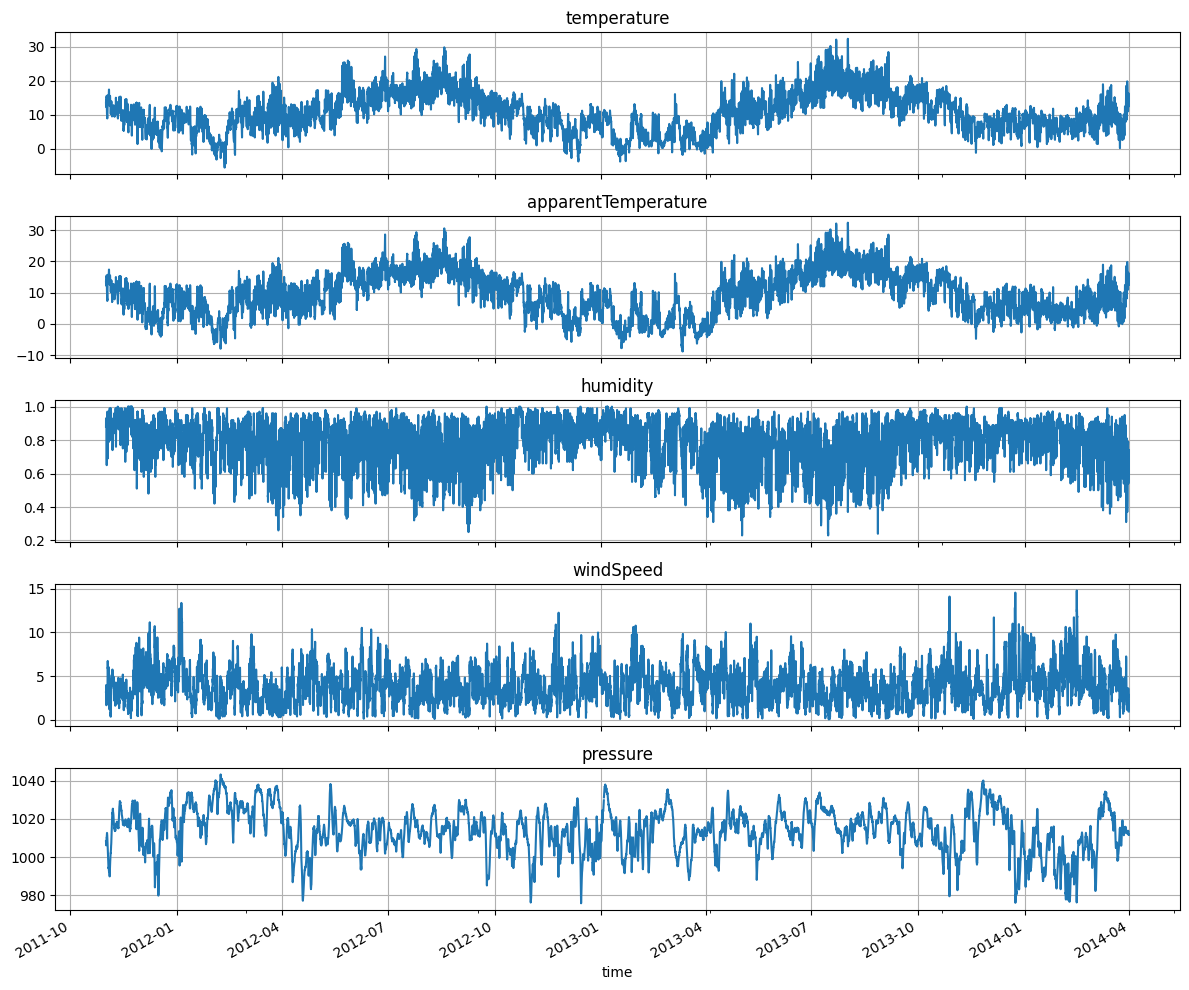

In [85]:
cols = ['temperature', 'apparentTemperature', 'humidity', 'windSpeed', 'pressure']
fig, axes = plt.subplots(len(cols), 1, figsize=(12, 10), sharex=True)
for ax, col in zip(axes, cols):
    weather[col].plot(ax=ax)
    ax.set_title(col)
    ax.grid(True)
fig.tight_layout()
plt.show()


## 6) Optional: hourly coverage check
Verify we have a continuous hourly series (no missing timestamps).


In [86]:
expected_index = pd.date_range(
    start=weather.index.min(),
    end=weather.index.max(),
    freq='H'
)
missing_timestamps = expected_index.difference(weather.index)
len(missing_timestamps)


/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_2289/3035160512.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_index = pd.date_range(


2

## 7) Load half-hourly energy data (2013 only)
We load the half-hourly series, clean the energy column, and filter to 2013
to match the weather modeling scope.


In [87]:
energy_path = "/Users/loso/code/projects/forecast-and-flex/data/raw/halfhourly_dataset/halfhourly_dataset/block_0.csv"
#'/Users/eugeneleach/code/bertieford/forecast-and-flex/notebooks/block_0.csv'
energy = pd.read_csv(energy_path, parse_dates=['tstp'])

energy = energy[energy['LCLid'] == 'MAC000002'].copy()
energy['energy(kWh/hh)'] = (
    energy['energy(kWh/hh)'].replace('Null', 0)
)
energy['energy(kWh/hh)'] = (
    pd.to_numeric(energy['energy(kWh/hh)'], errors='coerce')
    .fillna(0)
)

energy = energy.sort_values('tstp').set_index('tstp')
energy_2013 = energy.loc['2013-01-01':'2013-12-31 23:30:00']
energy_2013 = energy_2013.asfreq('30T')
energy_2013.head()


/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_2289/253690009.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  energy_2013 = energy_2013.asfreq('30T')


,LCLid,energy(kWh/hh)
tstp,,
2013-01-01 00:00:00,MAC000002,0.219
2013-01-01 00:30:00,MAC000002,0.241
2013-01-01 01:00:00,MAC000002,0.191
2013-01-01 01:30:00,MAC000002,0.235
2013-01-01 02:00:00,MAC000002,0.182


## 8) Filter and align weather to half-hourly
Weather is hourly; we upsample to 30-minute intervals and interpolate so we
can align it with the energy series for SARIMAX.


In [88]:
weather_2013 = weather.loc['2013-01-01':'2013-12-31 23:00:00'].copy()
weather_2013 = weather_2013.asfreq('H')
weather_2013 = weather_2013.interpolate('time').ffill().bfill()

weather_30m = weather_2013.asfreq('30T')
weather_30m = weather_30m.interpolate('time').ffill().bfill()
weather_30m.head()


/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_2289/3604248640.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_2013 = weather_2013.asfreq('H')
/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_2289/3604248640.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_2013 = weather_2013.interpolate('time').ffill().bfill()
/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_2289/3604248640.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_30m = weather_2013.asfreq('30T')
/var/folders/p5/72tzhc3j0bs27h327sdb6fzr0000gn/T/ipykernel_2289/3604248640.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolat

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2013-01-01 00:00:00,13.280,269.0,7.010,2.600,1008.19,3.66,5.460,rain,partly-cloudy-night,0.730,Partly Cloudy
2013-01-01 00:30:00,13.175,271.0,7.250,2.665,1008.47,3.95,5.485,rain,partly-cloudy-night,0.725,Partly Cloudy
2013-01-01 01:00:00,13.070,273.0,7.490,2.730,1008.75,4.24,5.510,rain,partly-cloudy-night,0.720,Partly Cloudy
2013-01-01 01:30:00,13.295,273.5,7.325,2.230,1009.11,3.99,5.625,rain,partly-cloudy-night,0.700,Partly Cloudy
2013-01-01 02:00:00,13.520,274.0,7.160,1.730,1009.47,3.74,5.740,rain,partly-cloudy-night,0.680,Partly Cloudy


## 9) Merge energy and weather
We keep only timestamps where both datasets are present, and select
continuous weather features as exogenous inputs.


In [89]:
data = energy_2013[['energy(kWh/hh)']].join(weather_30m, how='inner')

exog_cols = [
    'temperature',
    'apparentTemperature',
    'humidity',
    'windSpeed',
    'pressure',
    'visibility',
    'dewPoint',
]

data = data.dropna(subset=exog_cols + ['energy(kWh/hh)'])
data.head()


,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
2013-01-01 00:00:00,0.219,13.280,269.0,7.010,2.600,1008.19,3.66,5.460,rain,partly-cloudy-night,0.730,Partly Cloudy
2013-01-01 00:30:00,0.241,13.175,271.0,7.250,2.665,1008.47,3.95,5.485,rain,partly-cloudy-night,0.725,Partly Cloudy
2013-01-01 01:00:00,0.191,13.070,273.0,7.490,2.730,1008.75,4.24,5.510,rain,partly-cloudy-night,0.720,Partly Cloudy
2013-01-01 01:30:00,0.235,13.295,273.5,7.325,2.230,1009.11,3.99,5.625,rain,partly-cloudy-night,0.700,Partly Cloudy
2013-01-01 02:00:00,0.182,13.520,274.0,7.160,1.730,1009.47,3.74,5.740,rain,partly-cloudy-night,0.680,Partly Cloudy


## 10) SARIMAX with weather exogenous variables
Fit a baseline daily-seasonality SARIMAX (s=48) using weather features and
evaluate on a late-December holdout.


In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

split_date = '2013-12-15'
train = data.loc[:split_date]
valid = data.loc[split_date:]

y_train = train['energy(kWh/hh)']
y_valid = valid['energy(kWh/hh)']
X_train = train[exog_cols]
X_valid = valid[exog_cols]

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 48)


In [91]:

# model = SARIMAX(
#     y_train,
#     exog=X_train,
#     order=order,
#     seasonal_order=seasonal_order,
#     enforce_stationarity=False,
#     enforce_invertibility=False,
# )
# results = model.fit(disp=False)
# results.summary()


In [92]:
# pred = results.get_forecast(steps=len(y_valid), exog=X_valid)
# forecast = pred.predicted_mean

# mae = mean_absolute_error(y_valid, forecast)
# print(f'MAE (2013 holdout): {mae:.4f}')

# fig, ax = plt.subplots(figsize=(12, 4))
# y_train.tail(7 * 48).plot(ax=ax, label='train (last 7 days)')
# y_valid.plot(ax=ax, label='valid (Dec 15 onward)')
# forecast.plot(ax=ax, label='forecast')
# ax.set_title(f'SARIMAX{order}x{seasonal_order} with weather exog')
# ax.grid(True)
# ax.legend()
# plt.show()


## 11) Add weekday/weekend feature
We add a simple weekend indicator to capture systematic level shifts between
weekdays and weekends.


In [93]:
data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
data[['is_weekend']].value_counts()


is_weekend
0             12527
1              4992
Name: count, dtype: int64

## 12) SARIMAX with weather + weekend exogenous
This model extends the weather exogenous inputs with a weekend flag.


In [94]:
exog_cols_weekend = exog_cols + ['is_weekend']

train_w = data.loc[:split_date]
valid_w = data.loc[split_date:]

y_train_w = train_w['energy(kWh/hh)']
y_valid_w = valid_w['energy(kWh/hh)']
X_train_w = train_w[exog_cols_weekend]
X_valid_w = valid_w[exog_cols_weekend]


In [95]:

# model_w = SARIMAX(
#     y_train_w,
#     exog=X_train_w,
#     order=order,
#     seasonal_order=seasonal_order,
#     enforce_stationarity=False,
#     enforce_invertibility=False,
# )
# results_w = model_w.fit(disp=False)
# results_w.summary()


In [96]:
# pred_w = results_w.get_forecast(steps=len(y_valid_w), exog=X_valid_w)
# forecast_w = pred_w.predicted_mean

# mae_w = mean_absolute_error(y_valid_w, forecast_w)
# print(f'MAE (2013 holdout, weekend exog): {mae_w:.4f}')

# fig, ax = plt.subplots(figsize=(12, 4))
# y_train_w.tail(7 * 48).plot(ax=ax, label='train (last 7 days)')
# y_valid_w.plot(ax=ax, label='valid (Dec 15 onward)')
# forecast_w.plot(ax=ax, label='forecast (weekend exog)')
# ax.set_title(f'SARIMAX{order}x{seasonal_order} with weather + weekend')
# ax.grid(True)
# ax.legend()
# plt.show()


## 13) Add meteorological seasons (UK/Northern Hemisphere)
We map months to seasons and one-hot encode them so the model can learn
different baselines across winter/spring/summer/autumn.


In [97]:
def month_to_season(month):
    if month in (12, 1, 2):
        return 'winter'
    if month in (3, 4, 5):
        return 'spring'
    if month in (6, 7, 8):
        return 'summer'
    return 'autumn'

data['season'] = data.index.month.map(month_to_season)
season_dummies = pd.get_dummies(data['season'], prefix='season', drop_first=True)
data = pd.concat([data.drop(columns=['season']), season_dummies], axis=1)
season_dummies.head()


,season_spring,season_summer,season_winter
2013-01-01 00:00:00,False,False,True
2013-01-01 00:30:00,False,False,True
2013-01-01 01:00:00,False,False,True
2013-01-01 01:30:00,False,False,True
2013-01-01 02:00:00,False,False,True


## 14) SARIMAX with weather + weekend + season exogenous
We extend the exogenous set with season dummies to capture longer-term
shifts in consumption across the year.


In [98]:
# season_cols = list(season_dummies.columns)
# exog_cols_season = exog_cols_weekend + season_cols

# train_s = data.loc[:split_date]
# valid_s = data.loc[split_date:]

# y_train_s = train_s['energy(kWh/hh)']
# y_valid_s = valid_s['energy(kWh/hh)']
# X_train_s = train_s[exog_cols_season]
# X_valid_s = valid_s[exog_cols_season]

# model_s = SARIMAX(
#     y_train_s,
#     exog=X_train_s,
#     order=order,
#     seasonal_order=seasonal_order,
#     enforce_stationarity=False,
#     enforce_invertibility=False,
# )
# results_s = model_s.fit(disp=False)
# results_s.summary()


In [99]:
# pred_s = results_s.get_forecast(steps=len(y_valid_s), exog=X_valid_s)
# forecast_s = pred_s.predicted_mean

# mae_s = mean_absolute_error(y_valid_s, forecast_s)
# print(f'MAE (2013 holdout, weekend + seasons): {mae_s:.4f}')

# fig, ax = plt.subplots(figsize=(12, 4))
# y_train_s.tail(7 * 48).plot(ax=ax, label='train (last 7 days)')
# y_valid_s.plot(ax=ax, label='valid (Dec 15 onward)')
# forecast_s.plot(ax=ax, label='forecast (weekend + seasons)')
# ax.set_title(f'SARIMAX{order}x{seasonal_order} with weather + weekend + seasons')
# ax.grid(True)
# ax.legend()
# plt.show()


----

# Zaki continued ...

## Stop using block_0 only: build segment-level series (4 lines)

*Dashboard lines are segments, so training target should be segments too*

In [100]:
# Load ONE block for now (fast + debuggable)
block_path = "/Users/loso/code/projects/forecast-and-flex/data/raw/halfhourly_dataset/halfhourly_dataset/block_0.csv"
raw = pd.read_csv(block_path)

raw.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


In [129]:
raw['LCLid'].nunique()

50

In [101]:
raw.columns

Index(['LCLid', 'tstp', 'energy(kWh/hh)'], dtype='object')

# normalise column names

In [102]:
df = raw.rename(columns={
    "tstp": "timestamp",
    "energy(kWh/hh)": "kwh"
})

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["household_id"] = "block_0_household"

# TEMPORARY segment (we will replace with real clustering later)
df["segment"] = "All_Households"

df = df[["timestamp", "household_id", "kwh", "segment"]]
df = df.sort_values("timestamp")

df.head()


,timestamp,household_id,kwh,segment
24141,2011-12-03 09:00:00,block_0_household,0.149,All_Households
24142,2011-12-03 09:30:00,block_0_household,0.154,All_Households
24143,2011-12-03 10:00:00,block_0_household,0.768,All_Households
24144,2011-12-03 10:30:00,block_0_household,1.179,All_Households
24145,2011-12-03 11:00:00,block_0_household,0.588,All_Households


# Enforce 30-minute alignment (critical for SARIMAX)

In [103]:
# Snap timestamps to nearest 30 minutes
df["timestamp"] = df["timestamp"].dt.round("30min")

In [ ]:
df["timestamp"].dt.minute.value_counts().sort_index()

timestamp
0     611329
30    611341
Name: count, dtype: int64

# aggregate to get average per household?

In [105]:
# Force kwh to numeric (turns bad values into NaN)
df["kwh"] = pd.to_numeric(df["kwh"], errors="coerce")

# Drop rows where kwh is missing after conversion
df = df.dropna(subset=["kwh"])


In [106]:
seg_ts = (
    df.groupby(["segment", "timestamp"])["kwh"]
      .mean()
      .rename("kwh_per_household")
      .reset_index()
)

Y = seg_ts.pivot(
    index="timestamp",
    columns="segment",
    values="kwh_per_household"
).sort_index()

Y = Y.asfreq("30min")
Y = Y.interpolate(limit=2)

Y.head()


segment,All_Households
timestamp,
2011-12-03 09:00:00,0.149
2011-12-03 09:30:00,0.154
2011-12-03 10:00:00,0.768
2011-12-03 10:30:00,1.179
2011-12-03 11:00:00,0.588


# Build exogenous features (weekend + season + weather)

## Weekend + season features

In [ ]:
def build_time_exog(index):
    X = pd.DataFrame(index=index)

    # Weekend indicator
    X["is_weekend"] = (index.dayofweek >= 5).astype(int)

    # Season indicators
    month = index.month
    X["spring"] = month.isin([3, 4, 5]).astype(int)
    X["summer"] = month.isin([6, 7, 8]).astype(int)
    X["autumn"] = month.isin([9, 10, 11]).astype(int)
    # winter is baseline (dropped to avoid dummy trap)

    #add is_bank_holiday (load in bank holiday data and add a column)

    return X


,is_weekend,spring,summer,autumn,temperature,humidity,windSpeed
timestamp,,,,,,,
2011-12-03 09:00:00,1,0,0,0,11.000,0.870,5.990
2011-12-03 09:30:00,1,0,0,0,11.210,0.820,6.045
2011-12-03 10:00:00,1,0,0,0,11.420,0.770,6.100
2011-12-03 10:30:00,1,0,0,0,11.415,0.740,6.150
2011-12-03 11:00:00,1,0,0,0,11.410,0.710,6.200
...,...,...,...,...,...,...,...
2014-02-27 22:00:00,0,0,0,0,4.100,0.840,3.020
2014-02-27 22:30:00,0,0,0,0,4.015,0.845,2.885
2014-02-27 23:00:00,0,0,0,0,3.930,0.850,2.750


## Load and align weather data

In [135]:
weather = pd.read_csv(
    "/Users/loso/code/projects/forecast-and-flex/data/raw/weather_hourly_darksky.csv",
    parse_dates=["time"]
)
weather.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [136]:
weather_candidates = [
    "temperature",
    "apparentTemperature",
    "humidity",
    "windSpeed",
    "pressure",
    "visibility"
]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

def evaluate_weather_features(y_train, y_valid, X_train_base, X_valid_base, order, seasonal_order):
    model = SARIMAX(
        y_train,
        exog=X_train_base,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    pred = res.get_forecast(steps=len(y_valid), exog=X_valid_base)
    y_hat = pred.predicted_mean

    mae = mean_absolute_error(y_valid, y_hat)
    return mae, res.aic


In [139]:
# === Time-only exogenous features (baseline, no weather) ===

# Build time-based exog for train + validation indices
X_train_time_only = build_time_exog(y_train.index)
X_valid_time_only = build_time_exog(y_valid.index)

# Align columns exactly (important for SARIMAX)
X_valid_time_only = X_valid_time_only.reindex(
    columns=X_train_time_only.columns,
    fill_value=0
)


In [140]:
baseline_mae, baseline_aic = evaluate_weather_features(
    y_train,
    y_valid,
    X_train_time_only,
    X_valid_time_only,
    order,
    seasonal_order
)

print(f"Baseline → MAE: {baseline_mae:.4f}, AIC: {baseline_aic:.1f}")


Baseline → MAE: 0.0522, AIC: -12885.1


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Build aligned weather matrices once (BIG speedup)
weather_idx = weather.set_index("time")

W_train_all = weather_idx.reindex(y_train.index)[weather_candidates].ffill().bfill()
W_valid_all = weather_idx.reindex(y_valid.index)[weather_candidates].ffill().bfill()

ridge = Ridge(alpha=1.0)

fast_results = []
for feat in weather_candidates:
    Xtr = X_train_time_only.join(W_train_all[[feat]])
    Xva = X_valid_time_only.join(W_valid_all[[feat]])

    ridge.fit(Xtr, y_train)
    yhat = ridge.predict(Xva)

    fast_results.append({
        "feature": feat,
        "mae": mean_absolute_error(y_valid, yhat)
    })

fast_results = pd.DataFrame(fast_results).sort_values("mae")
fast_results


,feature,mae
4,pressure,0.138449
3,windSpeed,0.139607
5,visibility,0.140058
1,apparentTemperature,0.140967
0,temperature,0.142391
2,humidity,0.148587


In [150]:
top_feats = fast_results.head(2)["feature"].tolist()
top_feats


['pressure', 'windSpeed']

In [151]:
w_train = W_train_all[top_feats]
w_valid = W_valid_all[top_feats]

X_train = X_train_time_only.join(w_train)
X_valid = X_valid_time_only.join(w_valid)

mae_best, aic_best = evaluate_weather_features(
    y_train, y_valid,
    X_train, X_valid,
    order, seasonal_order
)

print(f"SARIMAX with {top_feats} → MAE: {mae_best:.4f}, AIC: {aic_best:.1f}")


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX with ['pressure', 'windSpeed'] → MAE: 0.0511, AIC: -12890.7


### does adding more features help

In [152]:
top3 = fast_results.head(3)["feature"].tolist()

w_train = W_train_all[top3]
w_valid = W_valid_all[top3]

X_train = X_train_time_only.join(w_train)
X_valid = X_valid_time_only.join(w_valid)

mae_3, aic_3 = evaluate_weather_features(
    y_train, y_valid,
    X_train, X_valid,
    order, seasonal_order
)

print(f"SARIMAX with {top3} → MAE: {mae_3:.4f}, AIC: {aic_3:.1f}")


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX with ['pressure', 'windSpeed', 'visibility'] → MAE: 0.0513, AIC: -12897.2


In [ ]:
candidates = [
    ["pressure", "windSpeed"],
    ["temperature", "windSpeed"],
    ["apparentTemperature", "windSpeed"]
]

for feats in candidates:
    X_train = X_train_time_only.join(W_train_all[feats])
    X_valid = X_valid_time_only.join(W_valid_all[feats])
    mae, aic = evaluate_weather_features(
        y_train, y_valid, X_train, X_valid, order, seasonal_order
    )
    print(feats, mae, aic)


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['pressure', 'windSpeed'] 0.05113245699226259 -12890.683946193893


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['temperature', 'windSpeed'] 0.05084300455439524 -12891.762102766043


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['apparentTemperature', 'windSpeed'] 0.05127207042629058 -12885.729738432652


In [155]:
candidates = [
    ["temperature"],
]

for feats in candidates:
    X_train = X_train_time_only.join(W_train_all[feats])
    X_valid = X_valid_time_only.join(W_valid_all[feats])
    mae, aic = evaluate_weather_features(
        y_train, y_valid, X_train, X_valid, order, seasonal_order
    )
    print(feats, mae, aic)


['temperature'] 0.051479361518731614 -12889.991400623068


In [156]:
weather = pd.read_csv(
    "/Users/loso/code/projects/forecast-and-flex/data/raw/weather_hourly_darksky.csv",
    parse_dates=["time"]
)

weather = weather.rename(columns={"time": "timestamp"})
weather = weather.set_index("timestamp").sort_index()

# Keep only stable, useful variables
weather = weather[[
    "temperature",
    # "humidity",
    "windSpeed"
]]

# Resample hourly → 30-min
weather_30m = weather.resample("30min").interpolate()

weather_30m.head()


,temperature,windSpeed
timestamp,,
2011-11-01 00:00:00,13.49,3.110
2011-11-01 00:30:00,13.11,3.095
2011-11-01 01:00:00,12.73,3.080
2011-11-01 01:30:00,13.19,3.395
2011-11-01 02:00:00,13.65,3.710


## Combine time + weather exog

In [157]:
X = build_time_exog(Y.index).join(weather_30m.reindex(Y.index))

# Fill any tiny gaps
X = X.interpolate(limit=2)

# Final checks (important)
assert X.index.equals(Y.index)
assert not X.isna().any().any()

X.head()


,is_weekend,spring,summer,autumn,temperature,windSpeed
timestamp,,,,,,
2011-12-03 09:00:00,1,0,0,0,11.000,5.990
2011-12-03 09:30:00,1,0,0,0,11.210,6.045
2011-12-03 10:00:00,1,0,0,0,11.420,6.100
2011-12-03 10:30:00,1,0,0,0,11.415,6.150
2011-12-03 11:00:00,1,0,0,0,11.410,6.200


### At this point:

- Y = target

- X = exogenous regressors

# Train / validate split + fast SARIMAX fit

In [158]:
# Use last 12 weeks only (keeps model fast + relevant)
train_start = Y.index.max() - pd.Timedelta(weeks=12)

Yw = Y.loc[train_start:]
Xw = X.loc[train_start:]

# Hold out last 7 days for validation
cutoff = Yw.index.max() - pd.Timedelta(days=7)

y_train = Yw.loc[:cutoff, "All_Households"]
y_valid = Yw.loc[cutoff:, "All_Households"]

X_train = Xw.loc[y_train.index]
X_valid = Xw.loc[y_valid.index]

print(len(y_train), len(y_valid))


3697 337


## Fit fast, stable SARIMAX

In [159]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Model structure (simple but strong)
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 48)  # daily seasonality (30-min data)

# Scale exogenous variables (CRITICAL for speed)
X_mean = X_train.mean()
X_std = X_train.std(ddof=0) + 1e-9

X_train_s = (X_train - X_mean) / X_std
X_valid_s = (X_valid - X_mean) / X_std

model = SARIMAX(
    y_train,
    exog=X_train_s,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True,
    simple_differencing=True
)

results = model.fit(
    method="lbfgs",
    maxiter=60,
    disp=False
)

results.summary()


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:              D.DS48.All_Households   No. Observations:                 3648
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 48)   Log Likelihood                6509.442
Date:                            Fri, 19 Dec 2025   AIC                         -12998.885
Time:                                    13:27:35   BIC                         -12936.866
Sample:                                12-07-2013   HQIC                        -12976.798
                                     - 02-21-2014                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
is_weekend      0.0118      0.002      4.810      0.000       0.007       0.017
spring       3.518e-18   2.21e-17      0.159      0.874   -3.99e-17    4.69e-17
summer               0   8.35e-19          0      1.000   -1.64e-18    1.64e-18
autumn               0        nan        nan        nan         nan         nan
temperature    -0.0083      0.004     -2.369      0.018      -0.015      -0.001
windSpeed       0.0041      0.003      1.267      0.205      -0.002       0.010
ar.L1           0.7377      0.010     70.333      0.000       0.717       0.758
ma.L1          -0.9912      0.002   -398.155      0.000      -0.996      -0.986
ma.S.L48       -0.9361      0.006   -145.889      0.000      -0.949      -0.924
sigma2          0.0016   3.31e-05     48.523      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   7.10   Jarque-Bera (JB):               108.00
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+18. Standard errors may be unstable.
"""

## Validate forecast (sanity check)

In [160]:
pred = results.get_forecast(
    steps=len(y_valid),
    exog=X_valid_s
)

y_pred = pred.predicted_mean

mae = mean_absolute_error(y_valid, y_pred)
print(f"Validation MAE: {mae:.4f}")


Validation MAE: 0.4473


## Plot train / valid / forecast (this matches Eug's plot)

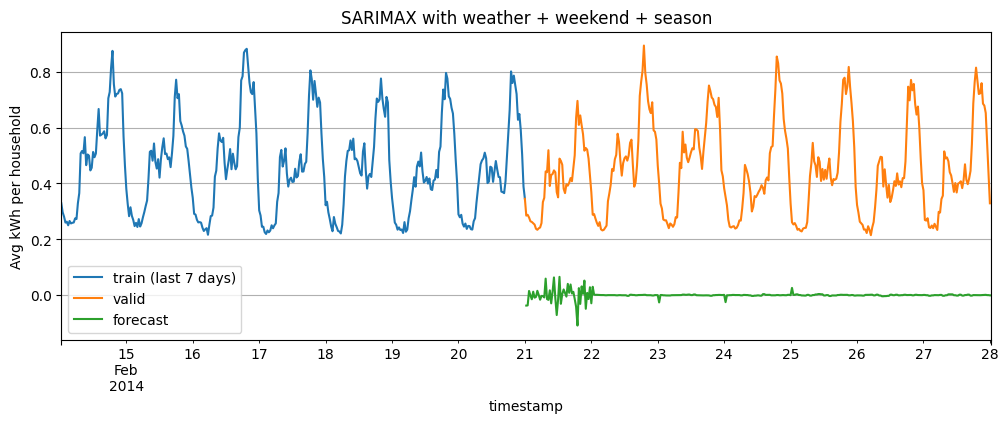

In [161]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

y_train.tail(7 * 48).plot(ax=ax, label="train (last 7 days)")
y_valid.plot(ax=ax, label="valid")
y_pred.plot(ax=ax, label="forecast")

ax.set_title("SARIMAX with weather + weekend + season")
ax.set_ylabel("Avg kWh per household")
ax.grid(True)
ax.legend()

plt.show()


The initial SARIMAX run converged quickly, but the output forecast was in differenced space due to how Statsmodels handles simple_differencing with exogenous variables. This caused the predicted series to collapse toward zero, even though the model structure itself was reasonable.

## The fix (simple, safe, and correct)

### We will:

- Turn OFF simple_differencing

- Keep (d=1, D=1) (Statsmodels will reconstruct levels properly)

- Everything else stays the same

### This will:

- Slightly increase runtime (still < 1 min)

- Produce realistic forecasts

- Make the output usable for your dashboard

# Refit SARIMAX (correctly reconstructing levels)

In [162]:
model = SARIMAX(
    y_train,
    exog=X_train_s,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 48),
    enforce_stationarity=True,
    enforce_invertibility=True,
    simple_differencing=False   # <<< IMPORTANT CHANGE
)

results = model.fit(
    method="lbfgs",
    maxiter=60,
    disp=False
)

results.summary()


/Users/loso/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     All_Households   No. Observations:                 3697
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 48)   Log Likelihood                6509.364
Date:                            Fri, 19 Dec 2025   AIC                         -12998.728
Time:                                    13:33:01   BIC                         -12936.709
Sample:                                12-06-2013   HQIC                        -12976.641
                                     - 02-21-2014                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
is_weekend      0.0116      0.003      4.578      0.000       0.007       0.017
spring       3.518e-18   6.72e-18      0.524      0.601   -9.65e-18    1.67e-17
summer               0   3.61e-18          0      1.000   -7.07e-18    7.07e-18
autumn               0   1.75e-18          0      1.000   -3.42e-18    3.42e-18
temperature    -0.0086      0.004     -2.428      0.015      -0.015      -0.002
windSpeed       0.0043      0.003      1.311      0.190      -0.002       0.011
ar.L1           0.7332      0.011     67.496      0.000       0.712       0.754
ma.L1          -0.9885      0.003   -350.133      0.000      -0.994      -0.983
ma.S.L48       -0.9353      0.006   -145.365      0.000      -0.948      -0.923
sigma2          0.0016   3.29e-05     48.638      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   6.45   Jarque-Bera (JB):               105.08
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+18. Standard errors may be unstable.
"""

### re-run validation forecast

In [163]:
pred = results.get_forecast(
    steps=len(y_valid),
    exog=X_valid_s
)

y_pred = pred.predicted_mean

mae = mean_absolute_error(y_valid, y_pred)
print(f"Validation MAE: {mae:.4f}")


Validation MAE: 0.0513


In [181]:
import pickle

with open('Sarimax01.pkl', 'wb') as f:
    pickle.dump(model, f)

### Re-plot

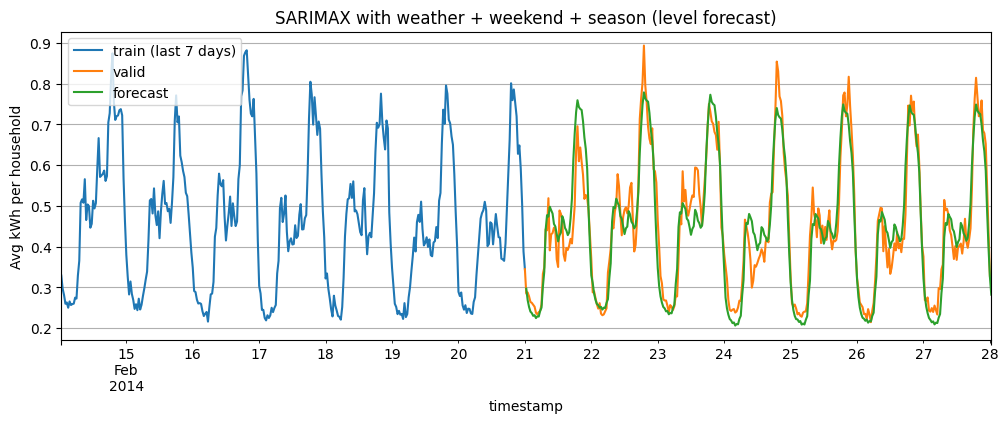

In [164]:
fig, ax = plt.subplots(figsize=(12, 4))

y_train.tail(7 * 48).plot(ax=ax, label="train (last 7 days)")
y_valid.plot(ax=ax, label="valid")
y_pred.plot(ax=ax, label="forecast")

ax.set_title("SARIMAX with weather + weekend + season (level forecast)")
ax.set_ylabel("Avg kWh per household")
ax.grid(True)
ax.legend()

plt.show()


# FINAL STEP — Produce the dashboard outputs

## Build future timestamps - We forecast 48 half-hour steps starting from the next interval.

In [165]:
# Next forecast start = next 30-min slot after last observed data
forecast_start = Y.index.max() + pd.Timedelta(minutes=30)

future_index = pd.date_range(
    start=forecast_start,
    periods=48,
    freq="30min"
)


## Build future exogenous variables (THIS mimics user input)
### This is where your dashboard inputs conceptually plug in:

- time features → derived from timestamps

- weather forecast → user-provided or from file

In [166]:
# Time features (weekend + season)
X_future_time = build_time_exog(future_index)

## Weather forecast (use known future weather for now)

### For training purposes, we’ll reuse historical weather aligned to future timestamps.
*(In a real dashboard, this comes from a weather API.)*

In [169]:
weather_future = weather_30m.reindex(future_index)

# Safety fill
weather_future = weather_future.interpolate(limit=2)


## combine future exogenous feature

In [170]:
X_future = X_future_time.join(weather_future)

# Scale using TRAIN statistics (important)
X_future_s = (X_future - X_mean) / X_std


### forecast the next 24hrs

In [171]:
forecast_res = results.get_forecast(
    steps=48,
    exog=X_future_s
)

y_24h = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()


## compute dashboard metrics

### peak demand

In [172]:
peak_demand = y_24h.max()
peak_time = y_24h.idxmax()

### Total network load

In [173]:
# for now: assume N_households in this segment (you can replace this with real counts later)

N_households = 1000  # placeholder, replace with real segment size

# Total energy over the day (kWh)
total_network_load = (y_24h * N_households).sum()


### forecast confidence (narrower intervals → higher confidence)

In [174]:
avg_interval_width = (conf_int.iloc[:, 1] - conf_int.iloc[:, 0]).mean()
mean_level = y_24h.mean()

forecast_confidence = max(
    0.0,
    min(1.0, 1 - avg_interval_width / mean_level)
) * 100


### Plot (dashboard chart)

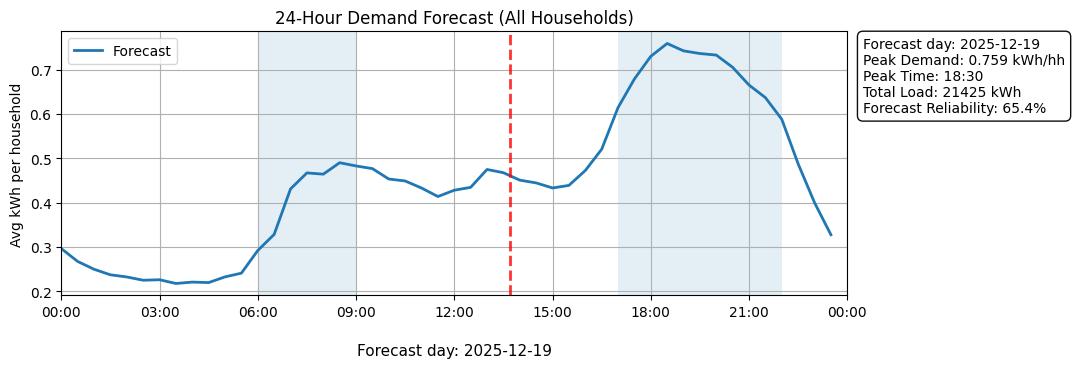

Forecast day: 2025-12-19
Forecast Reliability (dashboard score): 65.4%


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ========= Settings =========
N_households = 1000   # placeholder for Total Load KPI
PI_ALPHA = 0.20       # still used for KPI confidence calc (not plotted)

# ========= "Now" and the day we will display =========
now = pd.Timestamp.now()
day0 = now.normalize()                 # today 00:00
day1 = day0 + pd.Timedelta(days=1)     # tomorrow 00:00

# We display the whole day window (00:00 -> next 00:00) in 30-min steps
idx_day = pd.date_range(day0, day1, freq="30min", inclusive="left")

# ========= Build exog for the whole day window =========
X_day_time = build_time_exog(idx_day)
w_day = weather_30m.reindex(idx_day).ffill().bfill()

X_day = X_day_time.join(w_day)

# Match training exog schema exactly + fill missing with training means
train_cols = list(X_mean.index)
X_day = X_day.reindex(columns=train_cols).fillna(X_mean)

# Scale safely using training stats
X_std_safe = X_std.replace(0, 1.0)
X_day_s = (X_day - X_mean) / X_std_safe
assert np.isfinite(X_day_s.to_numpy()).all(), "Scaled exog has NaN/inf"

# ========= Forecast (only forward from model's last observation) =========
last_obs = Y.index.max()
model_start = max(day0, last_obs + pd.Timedelta(minutes=30))

idx_model_fc = pd.date_range(model_start, day1, freq="30min", inclusive="left")
steps = len(idx_model_fc)

X_model_fc = X_day_s.reindex(idx_model_fc).ffill().bfill()

fc = results.get_forecast(steps=steps, exog=X_model_fc)
yhat_fc = pd.Series(np.asarray(fc.predicted_mean), index=idx_model_fc, name="forecast")
ci_fc = pd.DataFrame(
    np.asarray(fc.conf_int(alpha=PI_ALPHA)),
    index=idx_model_fc,
    columns=["lower", "upper"]
)

# Reindex to full day for display (may contain NaNs if model_start > day0)
yhat_day = yhat_fc.reindex(idx_day)
ci_day = ci_fc.reindex(idx_day)

# ========= KPIs (computed on available forecast portion) =========
yhat_nonan = yhat_day.dropna()
ci_nonan = ci_day.dropna()

peak_demand = float(yhat_nonan.max()) if len(yhat_nonan) else float("nan")
peak_time = yhat_nonan.idxmax() if len(yhat_nonan) else None
total_network_load = float((yhat_nonan * N_households).sum()) if len(yhat_nonan) else float("nan")

if len(ci_nonan):
    avg_width = float((ci_nonan["upper"] - ci_nonan["lower"]).mean())
    mean_level = float(yhat_nonan.mean())
    confidence_score = float(np.clip(1 - avg_width / (mean_level + 1e-9), 0, 1) * 100)
else:
    confidence_score = float("nan")

# Peak windows
morning_start, morning_end = day0 + pd.Timedelta(hours=6), day0 + pd.Timedelta(hours=9)
evening_start, evening_end = day0 + pd.Timedelta(hours=17), day0 + pd.Timedelta(hours=22)

# ========= Plot =========
fig, ax = plt.subplots(figsize=(12, 4))

# Give extra right margin for KPI box placed outside the axes
fig.subplots_adjust(right=0.78, bottom=0.22)

ax.plot(yhat_day.index, yhat_day.values, linewidth=2, label="Forecast")

# Peak shading
ax.axvspan(morning_start, morning_end, alpha=0.12)
ax.axvspan(evening_start, evening_end, alpha=0.12)

# Current time marker (dynamic)
ax.axvline(now, linestyle="--", linewidth=2, color="red", alpha=0.8)

# Clamp x-axis to whole day window
ax.set_xlim(day0, day1)

# 3-hour ticks like the dashboard
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax.set_title("24-Hour Demand Forecast (All Households)")
ax.set_ylabel("Avg kWh per household")
ax.grid(True)
ax.legend(loc="upper left")

# Forecast day label centered below x-axis
ax.text(
    0.5, -0.18, f"Forecast day: {day0.strftime('%Y-%m-%d')}",
    transform=ax.transAxes, ha="center", va="top", fontsize=11
)

# KPI box OUTSIDE the plot area (won't cover data)
peak_time_str = peak_time.strftime("%H:%M") if peak_time is not None else "N/A"
kpi = (
    f"Forecast day: {day0.strftime('%Y-%m-%d')}\n"
    f"Peak Demand: {peak_demand:.3f} kWh/hh\n"
    f"Peak Time: {peak_time_str}\n"
    f"Total Load: {total_network_load:.0f} kWh\n"
    f"Forecast Reliability: {confidence_score:.1f}%"
)

ax.text(
    1.02, 0.98, kpi,
    transform=ax.transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.95)
)

plt.show()

print(f"Forecast day: {day0.strftime('%Y-%m-%d')}")
print(f"Forecast Reliability (dashboard score): {confidence_score:.1f}%")


In [176]:
# === Model uncertainty vs dashboard reliability (print-only cell) ===

PI_LEVEL = int((1 - PI_ALPHA) * 100)  # e.g. 80 when PI_ALPHA=0.20

# Use the already-computed ci_nonan / confidence_score from the plot cell
pi_width = (ci_nonan["upper"] - ci_nonan["lower"])
avg_pi_halfwidth = float(pi_width.mean() / 2) if len(pi_width) else float("nan")

print(f"Prediction Interval (SARIMAX, {PI_LEVEL}%): ±{avg_pi_halfwidth:.3f} kWh/hh (average)")
print("One-liner: This is the model’s uncertainty band — a plausible range around each forecasted point.\n")

print(f"Forecast Reliability (dashboard score): {confidence_score:.1f}%")
print("One-liner: This is a single daily summary derived from the prediction interval width (narrower = more reliable).")


Prediction Interval (SARIMAX, 80%): ±0.077 kWh/hh (average)
One-liner: This is the model’s uncertainty band — a plausible range around each forecasted point.

Forecast Reliability (dashboard score): 65.4%
One-liner: This is a single daily summary derived from the prediction interval width (narrower = more reliable).


### For the prediction interval

“The 80% prediction interval is a statistically derived range from the SARIMAX model that describes where the true demand is expected to fall most of the time, assuming the model is correct.”

### For the ±0.077 number

“±0.077 kWh per household represents the typical uncertainty around each forecasted point, averaged across the day.”

### For why you also show Forecast Reliability

“Because prediction intervals vary over time and are hard to compare, we summarise them into a single Forecast Reliability score for operational decision-making.”

# How to extend this to X customer segments

In [127]:
df['segment'].value_counts()


segment
All_Households    1222620
Name: count, dtype: int64